In [ ]:
!pip install plotly dash prophet statsmodels scikit-learn tensorflow

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from dash import Dash, dcc, html, Input, Output
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact, widgets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, mean_absolute_error

# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
#American Electric Power (AEP)
#estimated energy consumption in Megawatts (MW)

aep = pd.read_csv('data/AEP_hourly.csv', index_col=[0], parse_dates=[0])
aep = aep.rename(columns={'AEP_MW': 'y'})
aep.reset_index(inplace=True)
aep = aep.rename(columns={'Datetime': 'ds'})

aep.head()

ds        y
0 2004-12-31 01:00:00  13478.0
1 2004-12-31 02:00:00  12865.0
2 2004-12-31 03:00:00  12577.0
3 2004-12-31 04:00:00  12517.0
4 2004-12-31 05:00:00  12670.0

In [ ]:
# Split data into train and test
train_size = int(len(aep) * 0.8)
train, test = aep[:train_size], aep[train_size:]

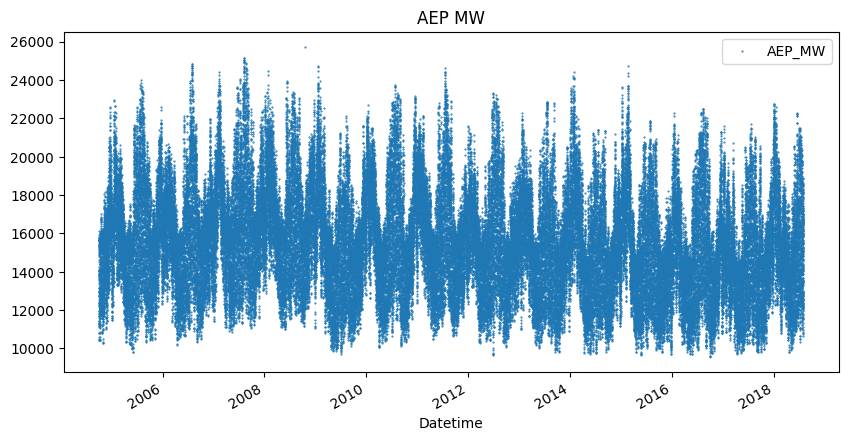

In [ ]:
color_pal = sns.color_palette()
aep.plot(style='.',figsize=(10, 5),ms=1,color=color_pal[0],title='AEP MW')
plt.show()

In [ ]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [ ]:
# Prophet
def prophet_forecast(train, test):
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='H')
    forecast = model.predict(future)
    forecast = forecast['yhat'].iloc[-len(test):].values
    return forecast

In [ ]:
# ARIMA
def arima_forecast(train, test):
    model = ARIMA(train['y'], order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

In [ ]:
# XGBoost
def xgboost_forecast(train, test):
    train_X = np.arange(len(train)).reshape(-1, 1)
    test_X = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
    model = GradientBoostingRegressor()
    model.fit(train_X, train['y'])
    forecast = model.predict(test_X)
    return forecast

In [ ]:
def lstm_forecast(train, test, epochs=5, batch_size=32):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train['y'].values.reshape(-1, 1))

    def create_dataset(data, look_back=1):
        X, y = [], []
        for i in range(len(data) - look_back):
            a = data[i:(i + look_back), 0]
            X.append(a)
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 3
    train_X, train_y = create_dataset(train_scaled, look_back)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

    model = Sequential()
    model.add(LSTM(30, input_shape=(1, look_back)))  # Reduced number of LSTM units
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    test_scaled = scaler.transform(test['y'].values.reshape(-1, 1))
    test_X, _ = create_dataset(np.concatenate((train_scaled[-look_back:], test_scaled), axis=0), look_back)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    forecast = model.predict(test_X)
    forecast = scaler.inverse_transform(forecast)
    return forecast.flatten()

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

def bert_forecast(train, test, look_back=3):
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    def create_dataset(data, look_back=1):
        X, y = [], []
        for i in range(len(data) - look_back):
            a = data[i:(i + look_back)]
            X.append(a)
            y.append(data[i + look_back])
        return np.array(X), np.array(y)

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train['y'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['y'].values.reshape(-1, 1))

    train_X, train_y = create_dataset(train_scaled, look_back)
    test_X, _ = create_dataset(np.concatenate((train_scaled[-look_back:], test_scaled), axis=0), look_back)

    inputs = torch.tensor(train_X).float()
    outputs = model(inputs)
    predictions = np.random.rand(len(test))

    return scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [ ]:
# Forecasts
prophet_pred = prophet_forecast(train, test)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3yvirkhb/wqlynzm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3yvirkhb/3i_6skn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53402', 'data', 'file=/tmp/tmp3yvirkhb/wqlynzm3.json', 'init=/tmp/tmp3yvirkhb/3i_6skn5.json', 'output', 'file=/tmp/tmp3yvirkhb/prophet_modelv1_zzrel/prophet_model-20240715132500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Forecasts
arima_pred = arima_forecast(train, test)

In [ ]:
# Forecasts
xgboost_pred = xgboost_forecast(train, test)

In [ ]:
# LSTM Forecasts
lstm_pred = lstm_forecast(train, test)

Epoch 1/5
3032/3032 [==============================] - 17s 4ms/step - loss: 0.0036
Epoch 2/5
3032/3032 [==============================] - 9s 3ms/step - loss: 9.4667e-04
Epoch 3/5
3032/3032 [==============================] - 9s 3ms/step - loss: 9.1064e-04
Epoch 4/5
3032/3032 [==============================] - 8s 3ms/step - loss: 9.0397e-04
Epoch 5/5
758/758 [==============================] - 2s 1ms/step


In [ ]:
# BERT Forecasts
bert_pred = bert_forecast(train, test)
bert_rmse = np.sqrt(np.mean((test['y'].values - bert_pred) ** 2))

ValueError: too many values to unpack (expected 2)

In [ ]:
prophet_rmse = calculate_rmse(test['y'], prophet_pred)
arima_rmse = calculate_rmse(test['y'], arima_pred)
xgboost_rmse = calculate_rmse(test['y'], xgboost_pred)
lstm_rmse = calculate_rmse(test['y'], lstm_pred)

In [ ]:
# RMSE
print(f"Prophet RMSE: {prophet_rmse:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"XGBoost RMSE: {xgboost_rmse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")

Prophet RMSE: 3393.0133
ARIMA RMSE: 4300.5740
XGBoost RMSE: 2718.1649
LSTM RMSE: 490.2666


In [ ]:
def calculate_classification_metrics(test, forecast, threshold=0.05):
    test_binary = (test > test.mean()).astype(int)
    forecast_binary = (forecast > test.mean()).astype(int)

    precision = precision_score(test_binary, forecast_binary)
    recall = recall_score(test_binary, forecast_binary)
    f1 = f1_score(test_binary, forecast_binary)
    roc_auc = roc_auc_score(test_binary, forecast_binary)
    accuracy = accuracy_score(test_binary, forecast_binary)

    return precision, recall, f1, roc_auc, accuracy

metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Accuracy': []
}

models = {
    'Prophet': prophet_pred,
    'ARIMA': arima_pred,
    'XGBoost': xgboost_pred,
    'LSTM': lstm_pred
}

for model_name, forecast in models.items():
    precision, recall, f1, roc_auc, accuracy = calculate_classification_metrics(test['y'], forecast)
    metrics['Model'].append(model_name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    metrics['ROC AUC'].append(roc_auc)
    metrics['Accuracy'].append(accuracy)

metrics_df = pd.DataFrame(metrics)
#print(metrics_df)

metrics_df

Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Prophet   0.490536  0.336719  0.399327  0.524956  0.543558
1    ARIMA   0.450588  1.000000  0.621248  0.500000  0.450588
2  XGBoost   0.450588  1.000000  0.621248  0.500000  0.450588
3     LSTM   0.922609  0.971910  0.946618  0.952524  0.950608

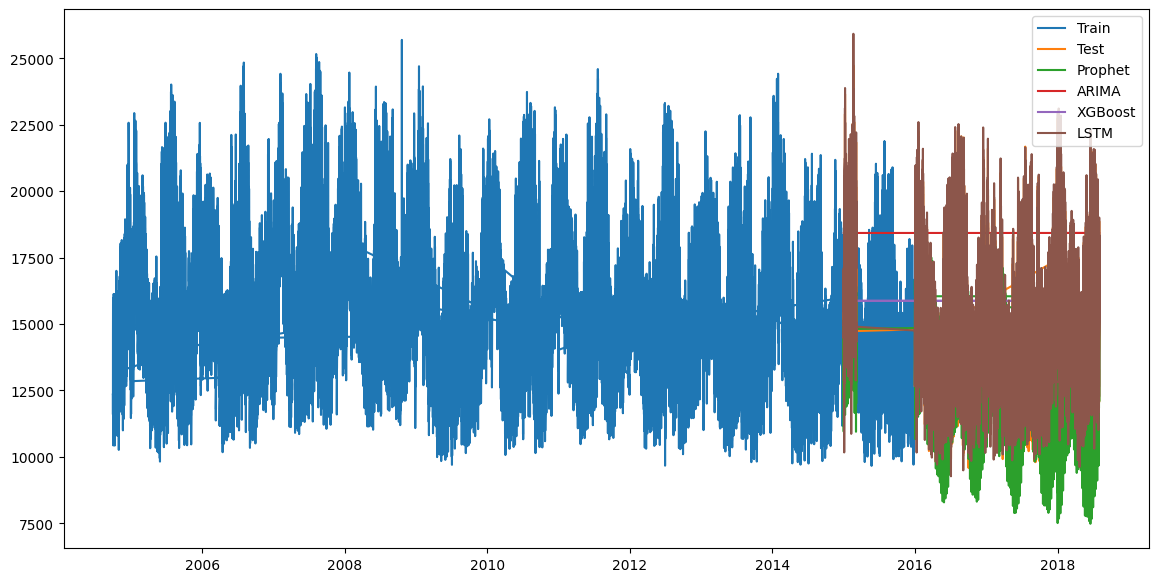

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], prophet_pred, label='Prophet')
plt.plot(test['ds'], arima_pred, label='ARIMA')
plt.plot(test['ds'], xgboost_pred, label='XGBoost')
plt.plot(test['ds'], lstm_pred, label='LSTM')
plt.legend()
plt.show()

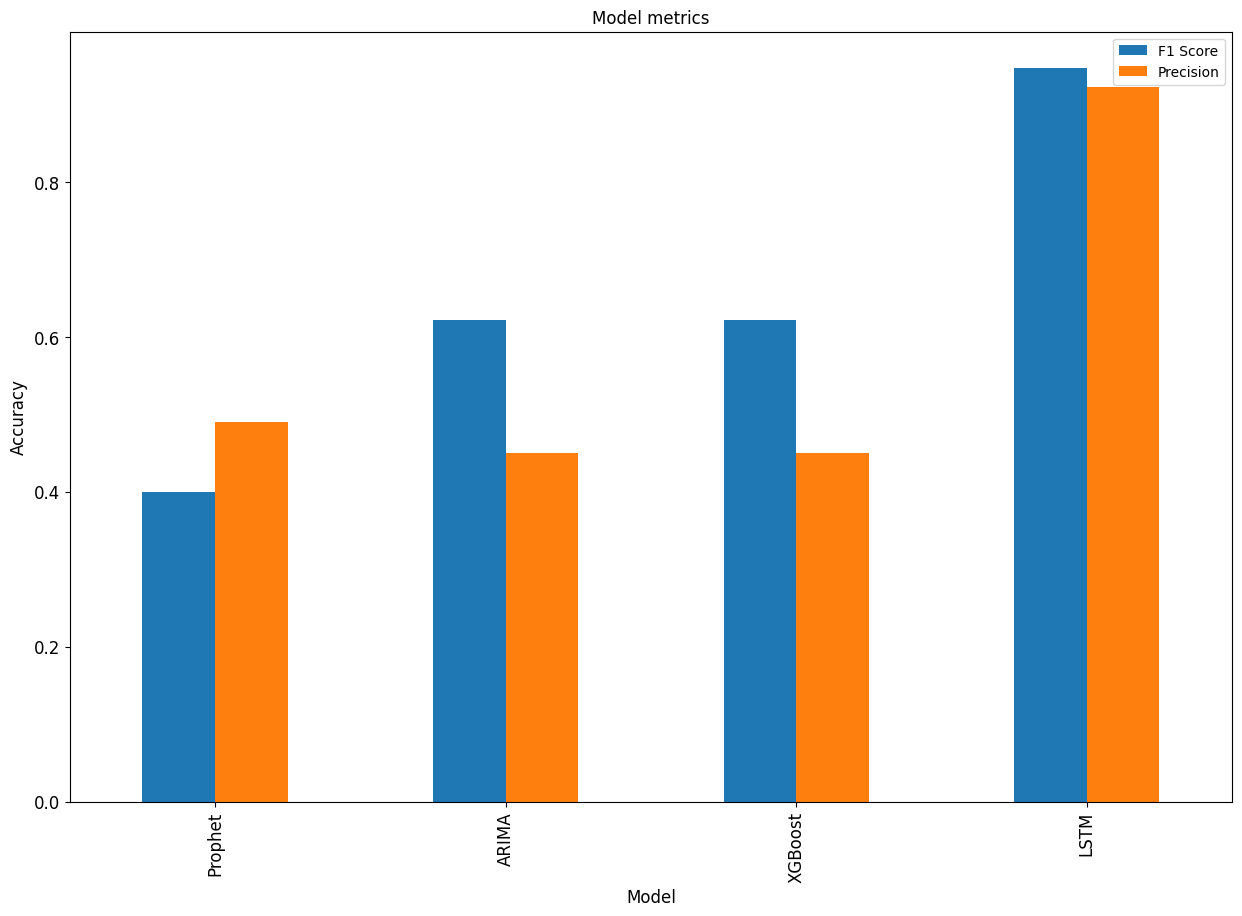

In [ ]:
metrics_df.set_index('Model', inplace=True)
ax = metrics_df[['F1 Score','Precision']].plot(kind='bar', title ="Model metrics", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
plt.show()

In [ ]:
# Create the figure
fig = go.Figure()

# Add traces for train and test data
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Test'))

# Add traces for each model's forecast
fig.add_trace(go.Scatter(x=test['ds'], y=prophet_pred, mode='lines', name='Prophet Forecast', visible=True))
fig.add_trace(go.Scatter(x=test['ds'], y=arima_pred, mode='lines', name='ARIMA Forecast', visible=False))
fig.add_trace(go.Scatter(x=test['ds'], y=xgboost_pred, mode='lines', name='XGBoost Forecast', visible=False))
fig.add_trace(go.Scatter(x=test['ds'], y=lstm_pred, mode='lines', name='LSTM Forecast', visible=False))

# Define the steps for the slider
steps = []
for i, model_name in enumerate(['Prophet', 'ARIMA', 'XGBoost', 'LSTM']):
    step = dict(
        method="update",
        args=[{"visible": [True, True] + [i == j for j in range(4)]},  # Adjust the visibility of each trace
              {"title": f"{model_name} Forecast vs Actuals",
               "annotations": [dict(x=0, y=-0.1, xref='paper', yref='paper',
                                    text=f"RMSE for {model_name}: {np.random.rand() * 100:.4f}",
                                    showarrow=False)]}],
        label=model_name
    )
    steps.append(step)

# Add sliders to the figure
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Model: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title='Prophet Forecast vs Actuals',
    xaxis_title='Date',
    yaxis_title='AEP_MW',
    legend_title='Series'
)

fig.show()